# Figure 7 : Temporal generalization rings

# Params

In [1]:
%run -n boillerplate.ipynb

# Temporal transpositions with 96 labels

In [2]:
try:
    #tempo_cms = np.load('./data/fig_6_probas_tempo_cms.npy')
    #tempo_probas = np.load('./data/fig_6_probas_tempo_probas.npy')
    tempo_likelihoods = np.load('./data/fig_6_probas_tempo_likelihoods.npy')
    # debug
except:
    tempo_probas = np.zeros((len(timesteps), len(timesteps), N_thetas*N_B_thetas))
    tempo_likelihoods = np.zeros((len(timesteps), len(timesteps), N_thetas*N_B_thetas, N_thetas*N_B_thetas))
    
    # Data
    try:
        data = np.load('./data/data_all_t_bt.npy')
        labels = np.load('./data/labels_all_t_bt.npy')
    except:    
        # Data
        data, labels, le = par_load_temporal_data(timesteps = timesteps, target_btheta = None,
                                                  target_theta = None, data_type = 'all_t_bt',
                                                  cluster_list = cluster_list)
        np.save('./data/data_all_t_bt.npy', data)
        np.save('./data/labels_all_t_bt.npy', labels)
        
    # Classifying
    random_state = 42
    for ibin_train in tqdm(range(data.shape[0]), desc = 'Training and testing') :
        xtrain, _, ytrain, __ = train_test_split(data[ibin_train, :, :], labels, test_size=test_size, random_state = random_state)
        logreg = LogisticRegression(**opts_LR)
        logreg.fit(xtrain, ytrain)
        
        for ibin_test in range(data.shape[0]):
            _, xtest, __, ytest = train_test_split(data[ibin_test, :, :], labels, test_size=test_size, random_state = random_state)
            
            # Returns the probability of the sample for each class in the model, where classes are ordered as they are in le.classes_.
            # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba
            proba = logreg.predict_proba(xtest)
            correct = logreg.predict(xtest) == ytest

            #cm = metrics.confusion_matrix(ytest, logreg.predict(xtest), normalize = 'all')
            # cm *= len(le.classes_)
            # tempo_cms[ibin_train, ibin_test, :, :] = cm
            
            # average probabilities for each class
            for i_test in np.unique(ytest):
                #tempo_probas[ibin_train, ibin_test, i_test] = correct[ytest==i_test].mean()
                tempo_likelihoods[ibin_train, ibin_test, i_test, :] = proba[ytest==i_test, :].mean(axis=0)
        
    #np.save('./data/fig_6_probas_tempo_cms.npy', tempo_cms)
    #np.save('./data/fig_6_probas_tempo_probas.npy', tempo_probas)
    np.save('./data/fig_6_probas_tempo_likelihoods.npy', tempo_likelihoods)
    


# With KFOLD

In [3]:
n_splits = 6

In [4]:
try:
    #tempo_cms = np.load('./data/fig_6_probas_tempo_cms.npy')
    #tempo_probas = np.load('./data/fig_6_probas_tempo_probas.npy')
    tempo_likelihoods = np.load('./data/fig_6_probas_tempo_likelihoods.npy')
    tempo_likelihoods_kf = np.load('./data/fig_6_probas_tempo_likelihoods_kf.npy')
    # debug
except:
    tempo_likelihoods_kf = np.zeros((len(timesteps), len(timesteps), N_thetas*N_B_thetas,n_splits, N_thetas*N_B_thetas))
    
    # Data
    try:
        data = np.load('./data/data_all_t_bt.npy')
        labels = np.load('./data/labels_all_t_bt.npy')
    except:    
        # Data
        data, labels, le = par_load_temporal_data(timesteps = timesteps, target_btheta = None,
                                                  target_theta = None, data_type = 'all_t_bt',
                                                  cluster_list = cluster_list)
        np.save('./data/data_all_t_bt.npy', data)
        np.save('./data/labels_all_t_bt.npy', labels)
        
    # Classifying
    random_state = 42
    kf = KFold(n_splits = n_splits)
    for ibin_train in tqdm(range(data.shape[0]), desc = 'Training and testing') :
        for i_kf, (train_index, test_index) in enumerate(kf.split(data[ibin_train,:,:])) :
            logreg = LogisticRegression(**opts_LR)
            xtrain, ytrain = data[ibin_train,train_index,:], labels[train_index] #is train on axis 1 or 2
            logreg.fit(xtrain, ytrain)

            for ibin_test in range(data.shape[0]):
                xtest, ytest = data[ibin_test,test_index,:], labels[test_index]

                # Returns the probability of the sample for each class in the model, where classes are ordered as they are in le.classes_.
                # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba
                proba = logreg.predict_proba(xtest)
                correct = logreg.predict(xtest) == ytest

                # average probabilities for each class
                for i_test in np.unique(ytest):
                    tempo_likelihoods_kf[ibin_train, ibin_test, i_test, i_kf, :] = proba[ytest==i_test, :].mean(axis=0)
        
    np.save('./data/fig_6_probas_tempo_likelihoods_kf.npy', tempo_likelihoods_kf)
    


In [5]:
np.save('./data/fig_6_probas_tempo_likelihoods_kf.npy', tempo_likelihoods_kf)

## along the diagonal for all different stimuli

In [6]:
if 0:
    idxs = range(N_B_thetas*N_thetas)

    n_cols = 8
    ibins = tempo_probas.shape[0]
    
    
    for i_row, idx in enumerate(idxs) :         
        fig, axs = plt.subplots(ncols = n_cols, nrows = 1, figsize = (3*n_cols, 3), subplot_kw=dict(projection="polar", aspect = 'equal'))

        proba = np.zeros((n_cols, N_B_thetas, N_thetas))
        for i_col in range(n_cols) :         
            start = (i_col*ibins)//n_cols
            stop = start + ibins//n_cols
            #print(start, stop, stop-start, len(range(start, stop)))
            for t in range(start, stop):
                proba[i_col, :, :] += tempo_likelihoods[t, t, idx, :].reshape((N_B_thetas, N_thetas))
            proba[i_col, :, :] /= stop-start
            
        for i_col in range(n_cols) :         
            ax = axs[i_col]
            pc = ax.pcolormesh(AZ*2, EL, proba[i_col, :, :].T,
                               cmap="coolwarm", edgecolors = 'none', linewidth = 0.,
                               antialiased = True, 
                               vmin = 0,
                               vmax = proba.max())

            ax.spines['polar'].set_visible(False)
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticklabels([])
            if i_col==0: ax.text(3*np.pi/4, EL.max()*1.4, f'k={i_row:03d}', c = 'k')
            start = (i_col*ibins)//n_cols
            ax.text(-3*np.pi/4, EL.max()*1.21, f't={timesteps[start]:.3f}', c = 'r')

        fig.tight_layout()
        plt.show()


## along the diagonal for different B_theta

Marginalization for the different thetas

In [7]:
tempo_probas_margin = np.zeros((len(timesteps), len(timesteps), N_B_thetas, N_thetas*N_B_thetas))
for idx in range(N_B_thetas*N_thetas):
    i_theta = idx % N_thetas # because that's how le.classes_ are ordered
    i_B_theta = idx // N_thetas
    # print(i_B_theta, i_theta)
    tempo_probas_margin[:, :, i_B_theta, :] += np.roll(tempo_likelihoods[:, :, idx, :], -i_theta, axis=2)/N_thetas

In [8]:
tempo_probas_margin.max()

0.4752897647297353

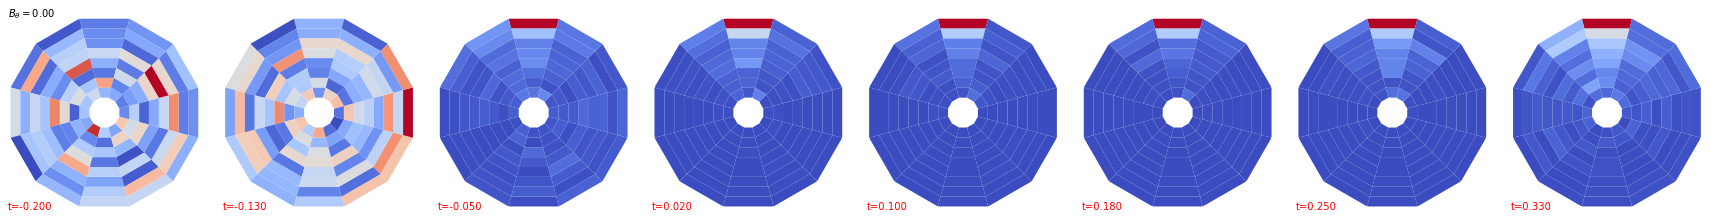

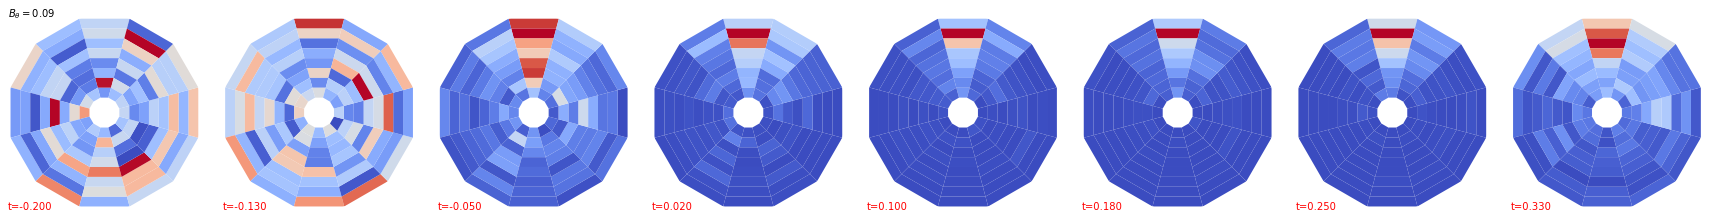

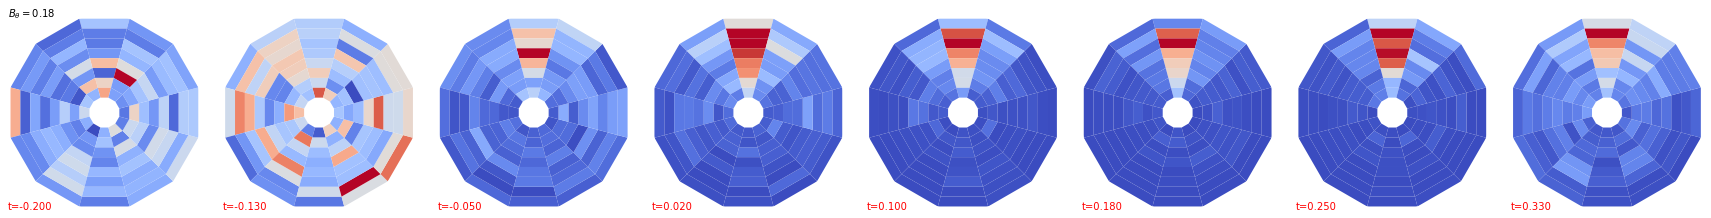

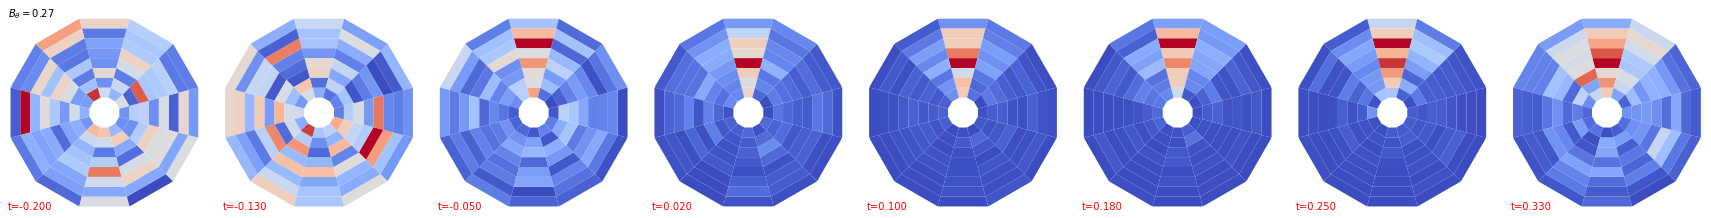

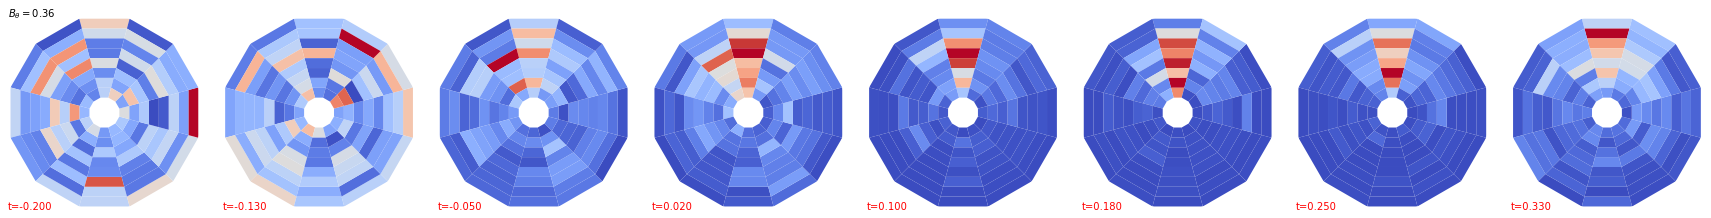

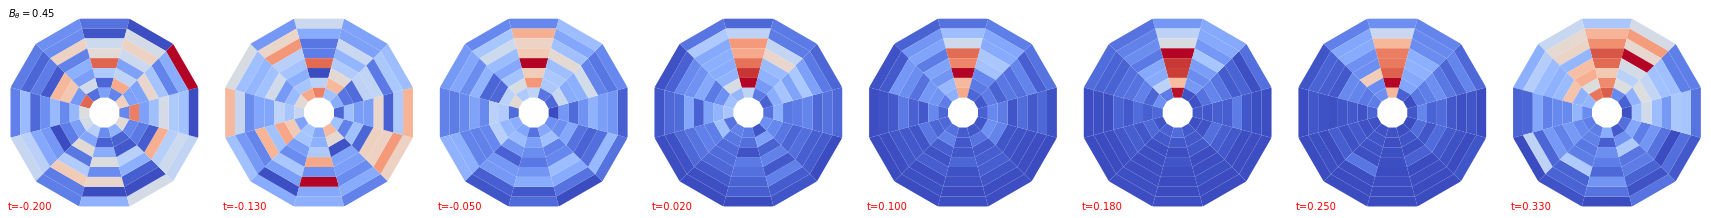

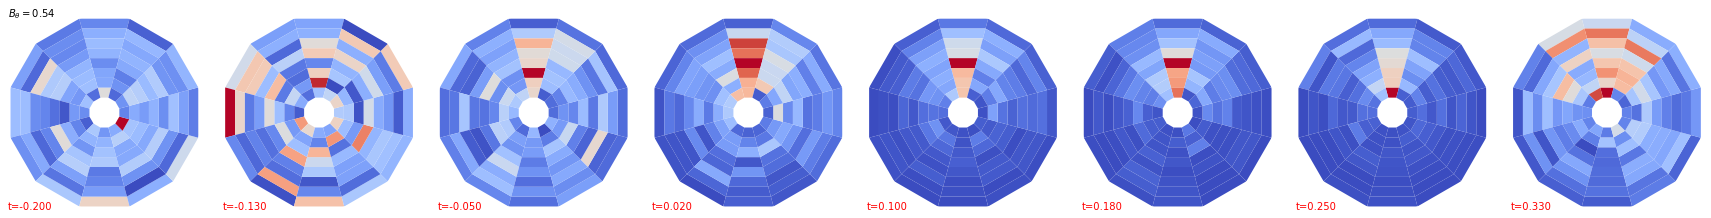

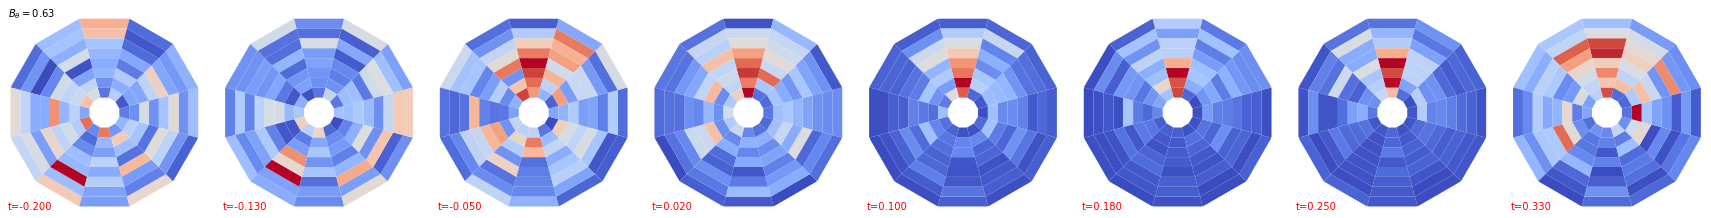

In [9]:
if True:
    idxs = range(N_B_thetas)

    n_cols = 8
    ibins = tempo_probas_margin.shape[0]
    
    
    for i_row, idx in enumerate(idxs) :         
        fig, axs = plt.subplots(ncols = n_cols, nrows = 1, figsize = (3*n_cols, 3), subplot_kw=dict(projection="polar", aspect = 'equal'))

        proba = np.zeros((n_cols, N_B_thetas, N_thetas))
        for i_col in range(n_cols) :    
            start = (i_col*ibins)//n_cols
            stop = start + ibins//n_cols
            #print(start, stop, stop-start, len(range(start, stop)))
            for t in range(start, stop):
                proba[i_col, :, :] += tempo_probas_margin[t, t, idx, :].reshape((N_B_thetas, N_thetas))
            proba[i_col, :, :] /= stop-start
            
        #proba = logit(proba)
        for i_col in range(n_cols) :         
            ax = axs[i_col]
            pc = ax.pcolormesh(AZ*2+np.pi/2-np.pi/N_thetas , EL, proba[i_col, :, :].T,
                               cmap="coolwarm", edgecolors = 'none', linewidth = 0.,
                               antialiased = True, 
                               #vmin = 0,
                              # vmax = proba.max()
                              )

            ax.spines['polar'].set_visible(False)
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticklabels([])
            if i_col==0: ax.text(3*np.pi/4, EL.max()*1.4, r'$B_\theta=%s$' % f'{B_thetas[::-1][i_row]:.2f}', c = 'k')
            start = (i_col*ibins)//n_cols
            ax.text(-3*np.pi/4, EL.max()*1.4, f't={timesteps[start]:.3f}', c = 'r')

        fig.tight_layout()
        plt.show()


# and with the Kfold

In [10]:
tempo_probas_margin_kf = np.zeros((len(timesteps), len(timesteps), N_B_thetas, N_thetas*N_B_thetas))
mean_kf = np.mean(tempo_likelihoods_kf, axis = 3)
for idx in range(N_B_thetas*N_thetas):
    i_theta = idx % N_thetas # because that's how le.classes_ are ordered
    i_B_theta = idx // N_thetas
    # print(i_B_theta, i_theta)
    tempo_probas_margin_kf[:, :, i_B_theta, :] += np.roll(mean_kf[:, :, idx, :], -i_theta, axis=2)/N_thetas

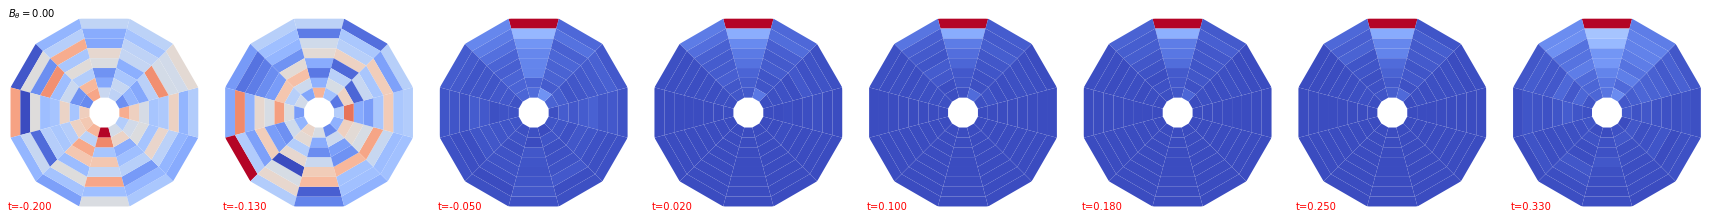

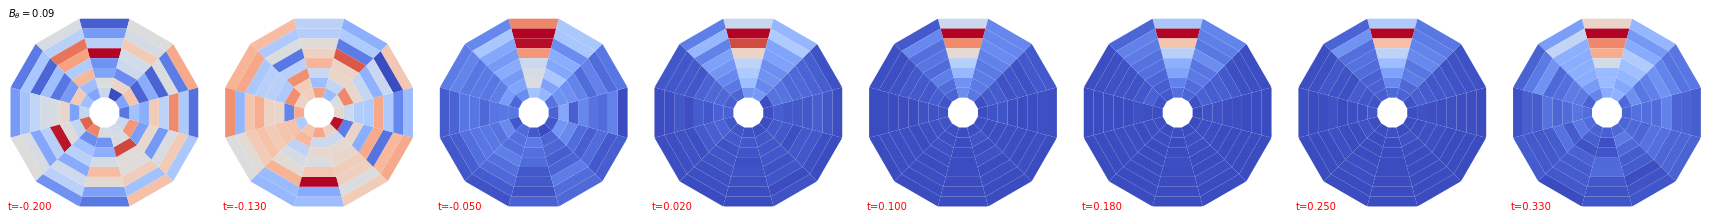

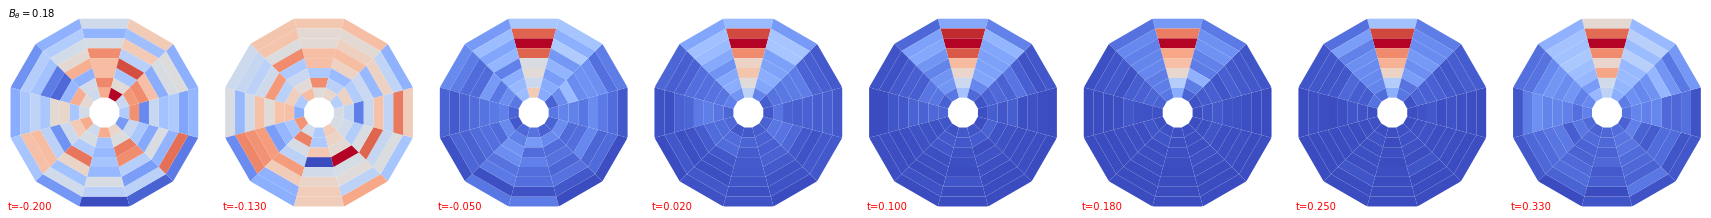

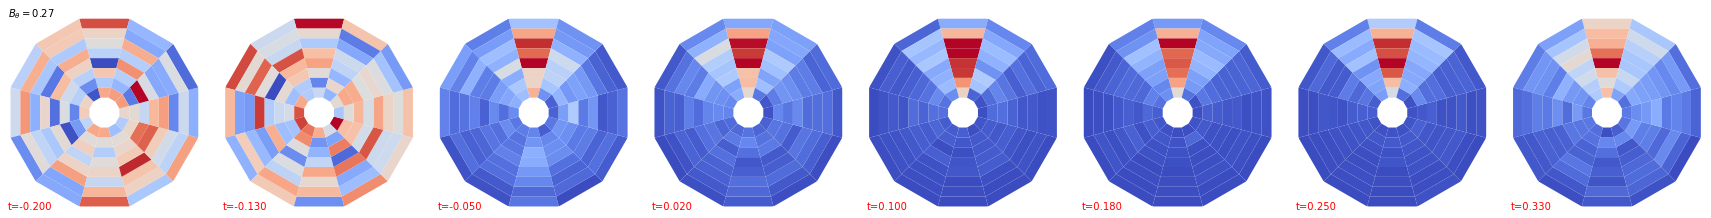

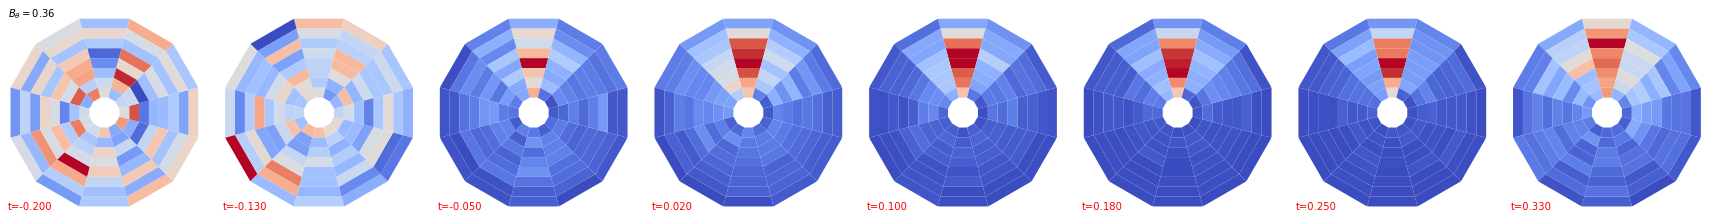

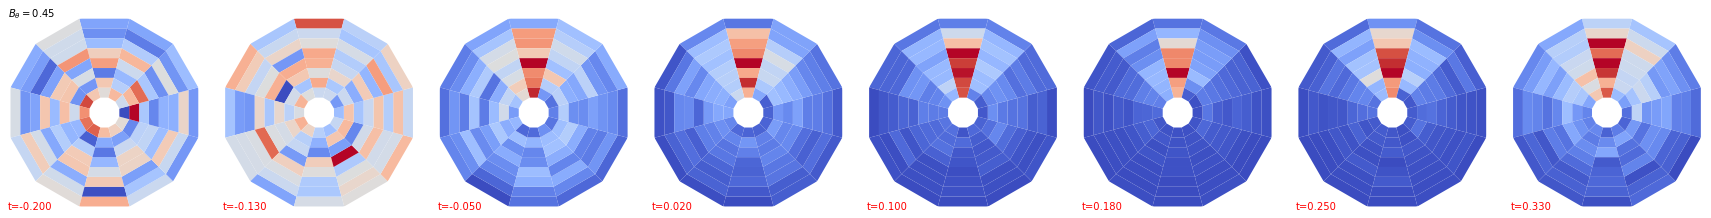

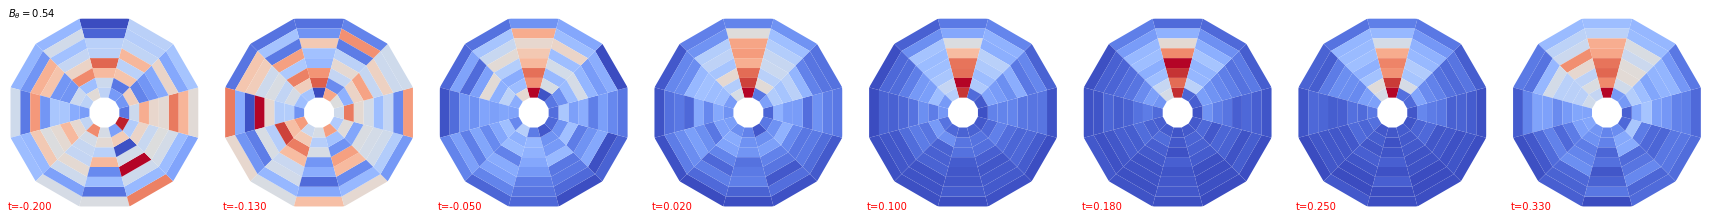

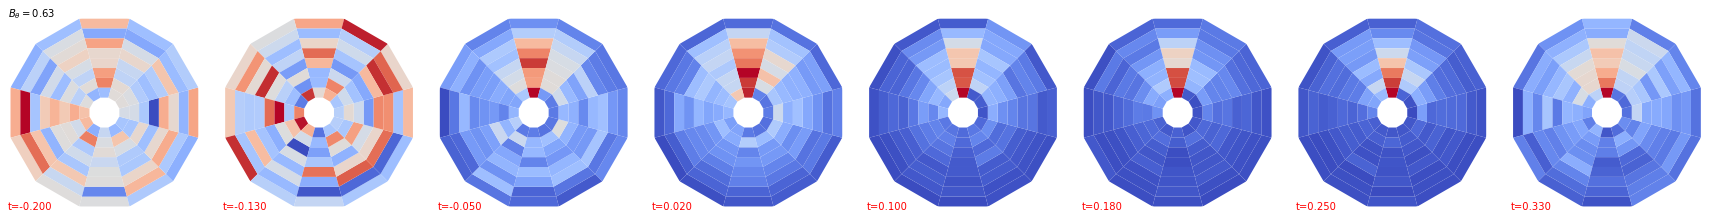

In [11]:
if True:
    idxs = range(N_B_thetas)

    n_cols = 8
    ibins = tempo_probas_margin_kf.shape[0]
    
    
    for i_row, idx in enumerate(idxs) :         
        fig, axs = plt.subplots(ncols = n_cols, nrows = 1, figsize = (3*n_cols, 3), subplot_kw=dict(projection="polar", aspect = 'equal'))

        proba = np.zeros((n_cols, N_B_thetas, N_thetas))
        for i_col in range(n_cols) :    
            start = (i_col*ibins)//n_cols
            stop = start + ibins//n_cols
            #print(start, stop, stop-start, len(range(start, stop)))
            for t in range(start, stop):
                proba[i_col, :, :] += tempo_probas_margin_kf[t, t, idx, :].reshape((N_B_thetas, N_thetas))
            proba[i_col, :, :] /= stop-start
            
        #proba = logit(proba)
        for i_col in range(n_cols) :         
            ax = axs[i_col]
            pc = ax.pcolormesh(AZ*2+np.pi/2-np.pi/N_thetas , EL, proba[i_col, :, :].T,
                               cmap="coolwarm", edgecolors = 'none', linewidth = 0.,
                               antialiased = True, 
                               #vmin = 0,
                              # vmax = proba.max()
                              )

            ax.spines['polar'].set_visible(False)
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticklabels([])
            if i_col==0: ax.text(3*np.pi/4, EL.max()*1.4, r'$B_\theta=%s$' % f'{B_thetas[::-1][i_row]:.2f}', c = 'k')
            start = (i_col*ibins)//n_cols
            ax.text(-3*np.pi/4, EL.max()*1.4, f't={timesteps[start]:.3f}', c = 'r')

        fig.tight_layout()
        plt.show()


# Refining it a little bit

In [12]:
B_thetas*180/np.pi

array([36.        , 30.85714286, 25.71428571, 20.57142857, 15.42857143,
       10.28571429,  5.14285714,  0.        ])

In [13]:
ibins

61

In [20]:
proba.shape

(3, 6, 8, 12)

<ipython-input-21-8b031cc7b09d>:49: UserWarning: Use the colorbar set_ticks() method instead.
  ax.set_xticks([])
<ipython-input-21-8b031cc7b09d>:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


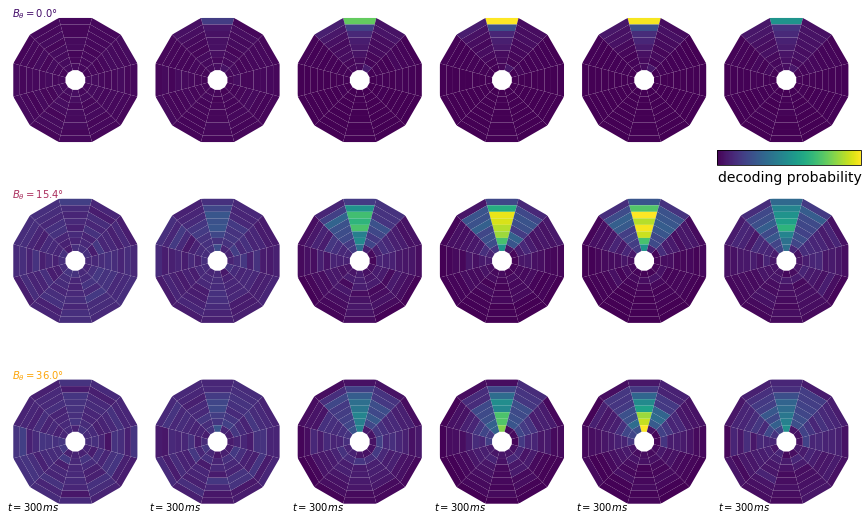

In [21]:
if True:
    
    # General params
    btt = [0,3,7] # B_thetas to display, reversed order from B_thetas (idx 0 = 36°)
    n_rows = len(btt)
    n_cols = 6 # number of time bins
    ibins = tempo_probas_margin_kf.shape[0]
    fig, axs = plt.subplots(figsize = (12, 8), subplot_kw=dict(projection="polar", aspect = 'equal'),
                            ncols= n_cols, nrows = n_rows)
    
    proba = np.zeros((len(btt), n_cols, N_B_thetas, N_thetas))
    for irow, bt in enumerate(btt) :
        for i_col in range(n_cols) :    
            start = (i_col*ibins)//n_cols
            stop = start + ibins//n_cols
            #print(start, stop, stop-start, len(range(start, stop)))
            for t in range(start, stop):
                proba[irow,i_col, :, :] += tempo_probas_margin_kf[t, t, bt, :].reshape((N_B_thetas, N_thetas))
            proba[irow, i_col, :, :] /= stop-start
            
    for irow, bt in enumerate(btt) :
        for i_col in range(n_cols) :
            ax = axs[irow, i_col]
            pc = ax.pcolormesh(AZ*2+np.pi/2-np.pi/N_thetas , EL, proba[irow,i_col, :, :].T,
                               cmap="viridis", edgecolors = 'none', linewidth = 0.,
                               antialiased = True,
                               vmin = np.min(proba[irow,:,:,:]), vmax = np.max(proba[irow,:,:,:])
                              )
            ax.spines['polar'].set_visible(False)
            
            if i_col==0:
                ax.text(3*np.pi/4, EL.max()*1.4, r'$B_\theta=%.1f°$' % (B_thetas[::-1][bt]*180/np.pi),
                       c = colors[::-1][bt])
                
            #start = (i_col*ibins)//n_cols
            if irow == 2 :
                ax.text(-3*np.pi/4, EL.max()*1.5, r'$t=%.0f ms$' % (timesteps[start]*1000), c = 'k')
                
            if i_col == 5 and irow == 0 :
                
                cax = fig.add_axes([5/6, 2/3, (1/6), 0.025])
                cb = fig.colorbar(pc, cax = cax, orientation='horizontal', ticks=[])
            
                cax.set_xlabel('decoding probability', labelpad=5, fontsize=14)

    for ax in fig.axes :
        
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticklabels([])
            

fig.tight_layout()
fig.savefig('./output/fig_7_probas.pdf', bbox_inches='tight', dpi=200, transparent=True)
plt.show()